In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from estnltk import Text
from estnltk_neural.taggers import StanzaSyntaxTagger

from estnltk_patches import EntityTagger
from estnltk_patches import SyntaxTree

In [3]:
stanza = StanzaSyntaxTagger()

## I. Simple example how to use stanza
I use here a webtagger as I do not have estnltk_neural set up on Apple M1.

Layer(name='stanza_syntax', attributes=('id', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel', 'deps', 'misc'), spans=SL[Span('Kui', [{'id': 1, 'lemma': 'kui', 'upostag': 'J', 'xpostag': 'J', 'feats': OrderedDict(), 'head': 5, 'deprel': 'mark', 'deps': '_', 'misc': '_'}]),
Span('Arno', [{'id': 2, 'lemma': 'Arno', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 5, 'deprel': 'advcl', 'deps': '_', 'misc': '_'}]),
Span('isaga', [{'id': 3, 'lemma': 'isa', 'upostag': 'S', 'xpostag': 'S', 'feats': OrderedDict([('sg', 'sg'), ('kom', 'kom')]), 'head': 5, 'deprel': 'obl', 'deps': '_', 'misc': '_'}]),
Span('koolimajja', [{'id': 4, 'lemma': 'koolimaja', 'upostag': 'S', 'xpostag': 'S', 'feats': OrderedDict([('adt', 'adt')]), 'head': 5, 'deprel': 'obl', 'deps': '_', 'misc': '_'}]),
Span('jõudis', [{'id': 5, 'lemma': 'jõudma', 'upostag': 'V', 'xpostag': 'V', 'feats': OrderedDict([('s', 's')]), 'head': 10, 'deprel': 'advcl', 'deps': '_', 'misc': '_'}]),
Span(',', [{'id': 6, 'lemma': ',', 'upostag': 'Z', 'xpostag': 'Z', 'feats': OrderedDict(), 'head': 5, 'deprel': 'punct', 'deps': '_', 'misc': '_'}]),
Span('olid', [{'id': 7, 'lemma': 'olema', 'upostag': 'V', 'xpostag': 'V', 'feats': OrderedDict([('sid', 'sid')]), 'head': 10, 'deprel': 'cop', 'deps': '_', 'misc': '_'}]),
Span('tunnid', [{'id': 8, 'lemma': 'tund', 'upostag': 'S', 'xpostag': 'S', 'feats': OrderedDict([('pl', 'pl'), ('n', 'n')]), 'head': 10, 'deprel': 'nsubj:cop', 'deps': '_', 'misc': '_'}]),
Span('juba', [{'id': 9, 'lemma': 'juba', 'upostag': 'D', 'xpostag': 'D', 'feats': OrderedDict(), 'head': 10, 'deprel': 'advmod', 'deps': '_', 'misc': '_'}]),
Span('alanud', [{'id': 10, 'lemma': 'alanud', 'upostag': 'A', 'xpostag': 'A', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 0, 'deprel': 'root', 'deps': '_', 'misc': '_'}]),
Span('.', [{'id': 11, 'lemma': '.', 'upostag': 'Z', 'xpostag': 'Z', 'feats': OrderedDict(), 'head': 10, 'deprel': 'punct', 'deps': '_', 'misc': '_'}])])

<module 'matplotlib.pyplot' from 'C:\\Users\\sormu\\Anaconda3\\envs\\estnltk_neuro\\lib\\site-packages\\matplotlib\\pyplot.py'>

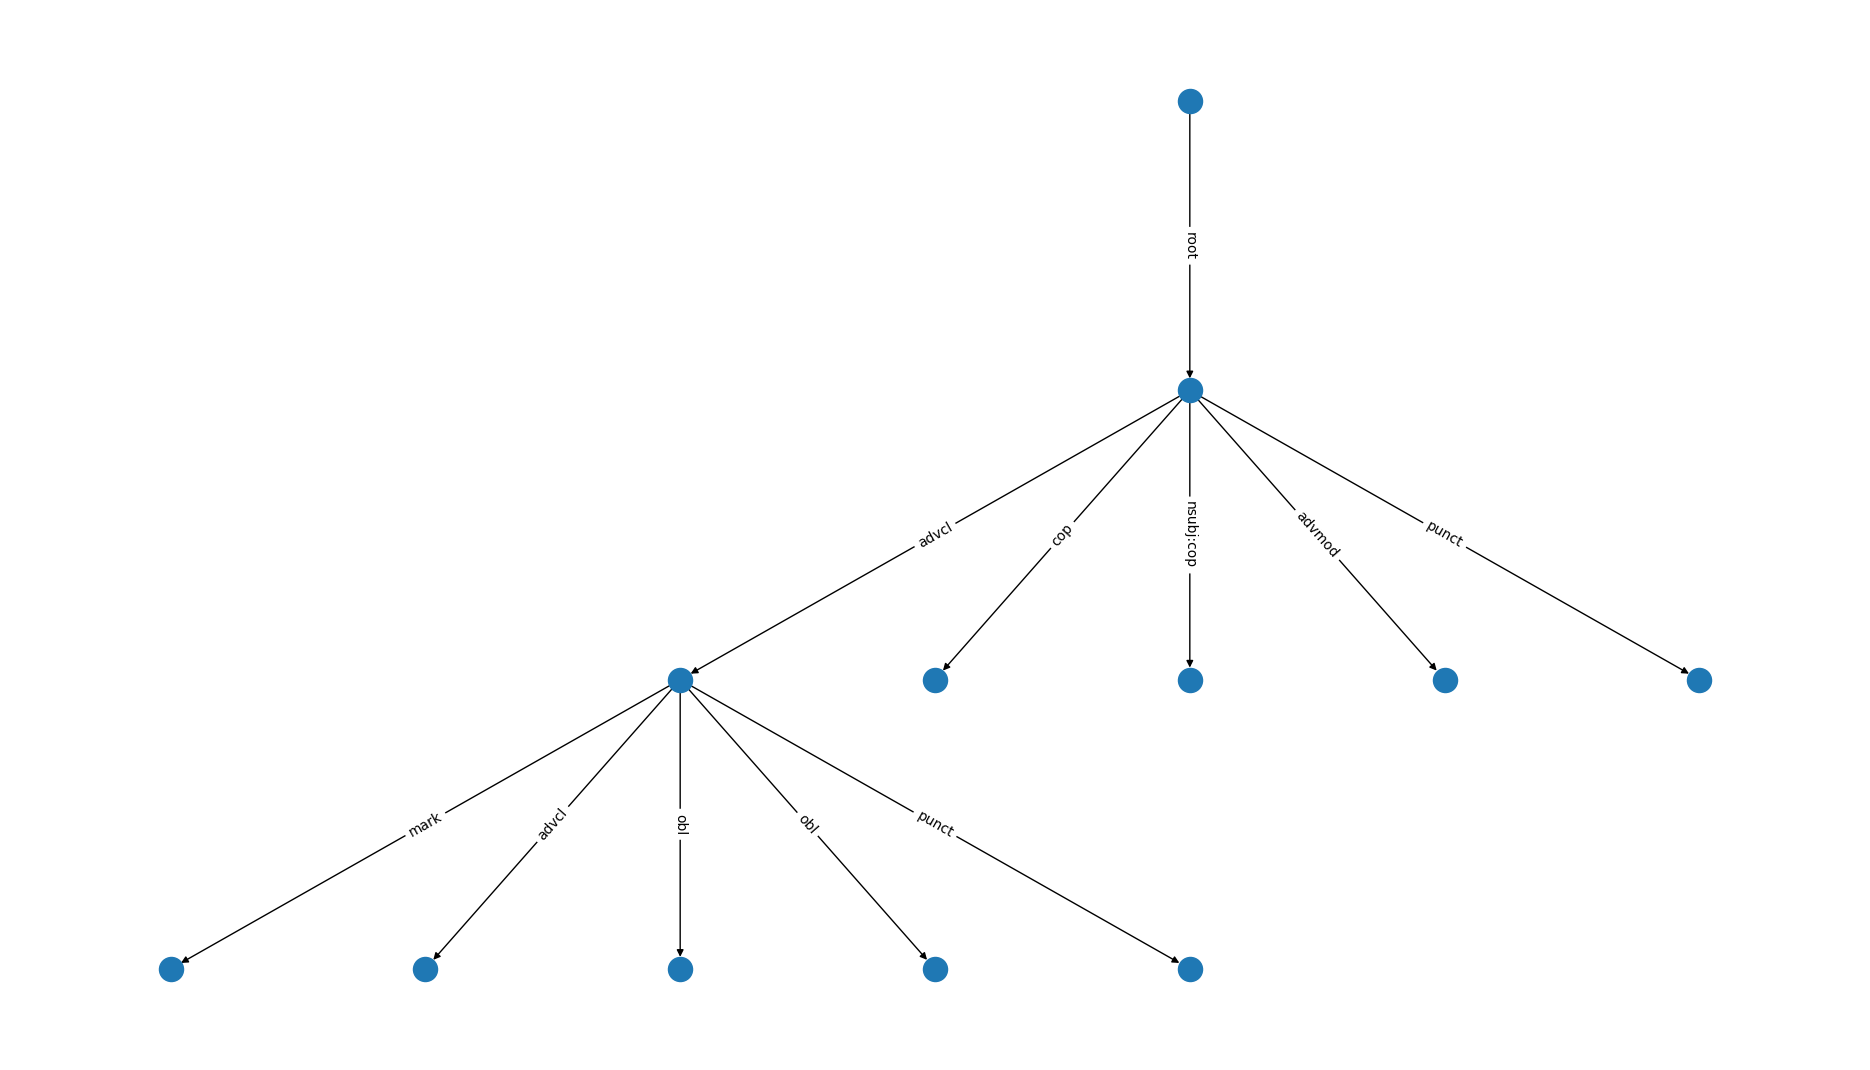

In [4]:
text = Text('Kui Arno isaga koolimajja jõudis, olid tunnid juba alanud.')
text.tag_layer('morph_extended')
stanza(text)
display(text['stanza_syntax'])
SyntaxTree(text['stanza_syntax']).drawGraph()

## II. Modified Entity extractor

In [5]:
obl_extractor = EntityTagger(deprel='obl', output_layer='entities')

In [6]:
text = Text('Kui Arno väriseva isaga rohelist värvi lagunevasse koolimajja jõudis, olid tunnid juba alanud.')
text.tag_layer('morph_extended')
stanza(text)
obl_extractor(text)
text['entities']

Layer(name='entities', attributes=('entity_type', 'free_entity', 'is_valid', 'root'), spans=SL[EnvelopingSpan(['väriseva', 'isaga'], [{'entity_type': None, 'free_entity': None, 'is_valid': None, 'root': <class 'estnltk_core.layer.span.Span'>}]),
EnvelopingSpan(['rohelist', 'värvi', 'lagunevasse', 'koolimajja'], [{'entity_type': None, 'free_entity': None, 'is_valid': None, 'root': <class 'estnltk_core.layer.span.Span'>}])])

In [7]:
text['entities'][0].root.text

'isaga'

## III. Finding locations

In [58]:
import pickle 
import random
import pandas as pd
from tqdm import tqdm
from os import listdir
from collections import Counter
from estnltk.taggers import NerTagger
from estnltk.corpus_processing.parse_koondkorpus import parse_tei_corpus

#### Finding all entities

In [47]:
result = parse_tei_corpus('Maaleht/ML/maaleht/aja_maaleht_2001/aja_ml_2001_32.tasak.xml')
result.extend(parse_tei_corpus('Maaleht/ML/maaleht/maaleht_2003/aja_ml_2003_31.xml'))
result.extend(parse_tei_corpus('Maaleht/ML/maaleht/maaleht_2002/aja_ml_2002_46.xml'))
result.extend(parse_tei_corpus('Maaleht/ML/maaleht/aja_maaleht_2001/aja_ml_2001_26.xml'))
result.extend(parse_tei_corpus('Maaleht/ML/maaleht/maaleht_2002/aja_ml_2002_03.xml'))

In [48]:
len(result)

225

In [11]:
sentences = []

for t in result:
    t.tag_layer()
    for sent in t.sentences:
        sent_text = " ".join(sent.text)
        sentences.append(Text(sent_text))

In [12]:
len(sentences)

10023

In [13]:
for sent in sentences:
    sent.tag_layer('morph_extended')
    stanza(sent)

In [14]:
for sent in sentences:
    try:
        obl_extractor(sent)
    except:
        continue

In [55]:
sentences[0]

Text(text='08.08.2001 Maarius Suviste')

In [59]:
tagger = NerTagger()

for sent in tqdm(sentences):
    tagger.tag(sent)

100%|████████████████████████████████████████████████████████████████████████████| 10023/10023 [09:21<00:00, 17.84it/s]


In [60]:
with open("original_sentences_with_analysis.pickle", "wb") as f:
    pickle.dump(sentences, f)

#### Keeping entities in a locative case

In [15]:
kohakaanded = ['sg ill', 'sg in', 'sg el', 'sg all', 'sg ad', 'sg abl', 
               'pl ill', 'pl in', 'pl el', 'pl all', 'pl ad', 'pl abl']

In [16]:
sentences[1].entities[0].root.form

,form
0,sg kom


In [17]:
all_loc_entities = []
all_loc_entities_text = []

for i, sent in enumerate(sentences):
    if i in [1118, 2534]:
        continue
    for span in sent['entities']:
        loc = False
        root_form = span.root.form[0]
        if root_form in kohakaanded:
            loc = True
        
        if loc:
            all_loc_entities.append(span)
            all_loc_entities_text.append(span.text)

In [18]:
len(all_loc_entities)

6650

6650 total entities that have the "obl" deprel and locative case. 4853 distinct "obl" locative entities.

In [19]:
all_loc_entities_tup = [tuple(ent) for ent in all_loc_entities_text]

In [156]:
len(set(all_loc_entities_tup))

4853

In [20]:
Counter(all_loc_entities_tup).most_common(10)

[(('Eestis',), 77),
 (('meil',), 51),
 (('sellest',), 49),
 (('mulle',), 40),
 (('endale',), 37),
 (('talle',), 35),
 (('tööle',), 34),
 (('mul',), 32),
 (('millest',), 32),
 (('sõnul',), 32)]

### Keeping only multi-word entities

In [21]:
all_loc_entities_several_word = []
all_loc_entities_text_several_word = []

for i, ent in enumerate(all_loc_entities_text):
    if len(ent) > 1:
        all_loc_entities_text_several_word.append(ent)
        all_loc_entities_several_word.append(all_loc_entities[i])

In [22]:
len(all_loc_entities_text_several_word)

3186

In [23]:
all_loc_entities_text_several_word_tup = [tuple(ent) for ent in all_loc_entities_text_several_word]

In [24]:
Counter(all_loc_entities_text_several_word_tup).most_common(10)

[(('igal', 'aastal'), 11),
 (('Eelmisel', 'aastal'), 8),
 (('Eelmisel', 'nädalal'), 8),
 (('samal', 'ajal'), 8),
 (('Samal', 'ajal'), 7),
 (('viimasel', 'ajal'), 7),
 (('õigel', 'ajal'), 6),
 (('sel', 'nädalal'), 6),
 (('igal', 'pool'), 5),
 (('sel', 'juhul'), 5)]

In [25]:
all_loc_entities_several_word[0].root.text

'aastatel'

In [26]:
several_word_root = []

for ent in all_loc_entities_several_word:
    several_word_root.append(ent.root.text)

In [27]:
Counter(several_word_root).most_common(10)

[('aastal', 99),
 ('sõnul', 84),
 ('ajal', 66),
 ('aastast', 29),
 ('nädalal', 28),
 ('juhul', 28),
 ('sellest', 28),
 ('alusel', 24),
 ('päeval', 23),
 ('suvel', 21)]

### Keeping all entity root words

Keeping root words from all entities that were in a locative case

In [28]:
all_root = []

for ent in all_loc_entities:
    all_root.append(ent.root.text)

In [192]:
len(all_root), len(set(all_root))

(6650, 3433)

6650 entities but keeping just the root there are 3433 distinct entity root words (as opposed to the previous ~4800 distinct entities).

In [30]:
Counter(all_root).most_common(10)

[('sõnul', 116),
 ('aastal', 103),
 ('Eestis', 92),
 ('sellest', 77),
 ('ajal', 70),
 ('meil', 53),
 ('mulle', 42),
 ('endale', 38),
 ('tööle', 38),
 ('suvel', 38)]

In [33]:
all_root_lemma = []

for ent in all_loc_entities:
    all_root_lemma.append(ent.root.lemma)

In [34]:
all_root_lemma[:3]

['aasta', 'ajalehekülg', 'vald']

In [35]:
len(all_root_lemma)

6650

### Wordnet

In [31]:
from estnltk.wordnet import Wordnet

In [32]:
wn = Wordnet()

In [36]:
all_loc_entities_hypernyms = []
all_loc_entities_highest = []

for i, lem in enumerate(all_root_lemma):
    try:
        syns = wn[lem][0]
        hypernym = syns.hypernyms
        highest = syns.closure("hypernym")[-1]
        all_loc_entities_hypernyms.append((all_root[i], lem, hypernym[0]))
        all_loc_entities_highest.append((all_root[i], lem, highest))
    except:
        continue

In [37]:
len(all_loc_entities_hypernyms), len(all_loc_entities_highest)

(4969, 4969)

In [38]:
hyp_literals = [ent[2].literal for ent in all_loc_entities_hypernyms]

In [39]:
Counter(hyp_literals).most_common(10)

[('kuu', 159),
 ('aasta', 158),
 ('keeleüksus', 123),
 ('aastaaeg', 113),
 ('inimene', 107),
 ('ajavahemik', 103),
 ('näit', 88),
 ('elusolend', 68),
 ('joon', 65),
 ('piirkond', 63)]

In [ ]:
# loc_time = [ent for ent in all_loc_entities_hypernyms if ent[2].literal in ["kuu", "aastaaeg", "ajavahemik", "koht", "nädalapäev", "aasta", "maa", "maa-asula", "mander", "asula"]]

#### Finding all words related to a location or time according to Wordnet hypernyms

In [69]:
loc_time_hypernyms = ["kuu", "aasta", "aastaaeg", "ajavahemik", "piirkond", "koht", "äritegevuskoht", "maa", "ajaühik",
                     "nädalapäev", "asula", "tegevusala", "aeg", "ala", "maa-asula", "eluruum", "rahvusriik", "hoone",
                     "ruum", "maapind", "päev", "maa-ala", "mander", "tuba", "asukoht", "linn"]

In [68]:
Counter(hyp_literals).most_common(100)

[('kuu', 159),
 ('aasta', 158),
 ('keeleüksus', 123),
 ('aastaaeg', 113),
 ('inimene', 107),
 ('ajavahemik', 103),
 ('näit', 88),
 ('elusolend', 68),
 ('joon', 65),
 ('piirkond', 63),
 ('spektrivärv', 58),
 ('kohustus', 57),
 ('sotsiaalne grupp', 55),
 ('tegevus', 54),
 ('koht', 54),
 ('abstraktsioon', 53),
 ('inimtegevus', 51),
 ('äritegevuskoht', 48),
 ('kehaosa', 46),
 ('üritus', 44),
 ('maa', 44),
 ('suhtlus', 41),
 ('ajaühik', 39),
 ('reisija', 39),
 ('nädalapäev', 38),
 ('organ', 34),
 ('asula', 34),
 ('suurus', 32),
 ('hulk', 32),
 ('tegevusala', 31),
 ('aeg', 30),
 ('kogu', 30),
 ('seisund', 30),
 ('miski', 28),
 ('ala', 28),
 ('maa-asula', 25),
 ('naturaalarv', 25),
 ('osa', 25),
 ('eluruum', 25),
 ('liige', 24),
 ('organisatsioon', 23),
 ('looduslik fenomen', 23),
 ('rahvusriik', 23),
 ('pind', 23),
 ('hoone', 23),
 ('mentaalne objekt', 22),
 ('punkt', 22),
 ('looduslik objekt', 21),
 ('mees', 21),
 ('farm', 21),
 ('paber', 21),
 ('taimeosa', 21),
 ('ruum', 21),
 ('muutumine'

In [70]:
loc_time = [ent for ent in all_loc_entities_hypernyms if ent[2].literal in loc_time_hypernyms]

In [71]:
len(loc_time), len(set(loc_time))

(1154, 339)

In [186]:
len(set([ent[0] for ent in loc_time]))

333

1154 out of 6650 of all obl locative entities (or 333 out of 4853 distinct entities) have a hypernym that refers to a location or time.

In [72]:
loc_time[:3]

[('aastatel', 'aasta', "Synset('aasta.n.02')"),
 ('erialal', 'eriala', "Synset('tegevusala.n.01')"),
 ('tulevikule', 'tulevik', "Synset('aeg.n.02')")]

In [167]:
loc_time_with_hypernyms = [(ent[0], ent[1], ent[2].literal) for ent in all_loc_entities_hypernyms if ent[2].literal in loc_time_hypernyms]

In [79]:
loc_time_hyp_df = pd.DataFrame(loc_time_with_hypernyms, columns=["kohamäärus", "lemma", "hüpernüüm"])

In [87]:
loc_time_hyp_df.to_csv("loc_time_with_hypernyms.csv", encoding="UTF-8-sig", index=False)

#### Keeping all words that did not have location/time hypernyms

In [89]:
len(all_root), len(loc_time)

(6650, 1154)

In [91]:
loc_time_word = [tup[0] for tup in loc_time]

In [93]:
loc_time_word[:3]

['aastatel', 'erialal', 'tulevikule']

In [95]:
non_loc_time_root = [w for w in all_root if w not in loc_time_word]

In [157]:
len(non_loc_time_root), len(set(non_loc_time_root))

(5496, 3100)

5496 (3100 distinct) obl locative entities remain after removing obvious location and time related words using Wordnet.

#### Keeping all words that are not NER locations

In [142]:
ner_entities = []

for sent in sentences:
    for ner_entity in sent.ner:
        if ner_entity.nertag == "LOC":
            ner_entities.append(ner_entity.text)

In [143]:
len(ner_entities)

2974

In [144]:
ner_entities[:3]

[['Saaremaal'], ['Saaremaal'], ['Laimjala', 'vallas']]

In [146]:
len([ent for ent in ner_entities if len(ent) == 1])

2699

In [148]:
len([ent for ent in ner_entities if len(ent) > 1])

275

In [147]:
[ent for ent in ner_entities if len(ent) > 1]

[['Laimjala', 'vallas'],
 ['Eesti', 'küla'],
 ['Eesti', 'riigil'],
 ['Pöide', 'vallas'],
 ['Kakuna', 'külas'],
 ['Laimjala', 'vallas'],
 ['Euroopa', 'Liidu'],
 ['Euroopa', 'Liiduga'],
 ['Eesti', 'riigi'],
 ['Pärnu', 'linna-'],
 ['Ridala', 'valla'],
 ['Ridala', 'valla'],
 ['Euroopa', 'Liitu'],
 ['Vinni', 'vallast'],
 ['Jõgeva', 'vallast'],
 ['Jõgeva', 'valla'],
 ['Maidla', 'vallast'],
 ['Elva', 'linnaga'],
 ['Tartumaa', 'valdades'],
 ['Rannu', 'vald'],
 ['Eesti', 'riigil'],
 ['Võnnu', 'vald'],
 ['Tartu', 'linnaga'],
 ['Järvamaa', 'vallad'],
 ['Türi', 'linn'],
 ['Vastseliina', 'vallas'],
 ['Kündja', 'külas'],
 ['Rapla', 'maakonna'],
 ['Rapla', 'linna'],
 ['Vastemõisa', 'valla'],
 ['Pärsti', 'vallast'],
 ['Balti', 'riikidest'],
 ['Paide', 'vald'],
 ['Väike-Maarja', 'vald'],
 ['Leisi', 'vallas'],
 ['Leisi', 'valla'],
 ['Kirde-Eesti', 'raudteepargi'],
 ['Rapla', 'maakonna'],
 ["Strasbourg'i", 'linnas'],
 ['Orissa', 'osariigis'],
 ['Purtse', 'jõe'],
 ['Aa', 'küla'],
 ['Narva', 'jõe'],
 ['Ees

In [149]:
one_word_ner = [ent[0] for ent in ner_entities if len(ent) == 1]

In [151]:
non_loc_time_root[:3]

['ajaleheküljest', 'vallas', 'perekonnas']

In [183]:
len(set(one_word_ner))

832

In [152]:
remaining_adv = [ent for ent in non_loc_time_root if ent not in one_word_ner]

In [153]:
len(remaining_adv)

5266

In [154]:
len(set(non_loc_time_root)), len(set(remaining_adv))

(3100, 3048)

NER locations remove 52 distinct location references.

In [158]:
Counter(remaining_adv).most_common(10)

[('sõnul', 116),
 ('sellest', 77),
 ('ajal', 70),
 ('meil', 53),
 ('mulle', 42),
 ('endale', 38),
 ('tööle', 38),
 ('talle', 37),
 ('mul', 33),
 ('millest', 32)]

#### Removing words related to persons

First removing pronouns

In [159]:
asesonad = set()
asesonad_lemma = set()

for sentence in sentences:
    for word in sentence.stanza_syntax:
        pos = word["upostag"]
        if pos == "P":
            asesonad.add(word.text)
            asesonad_lemma.add(word.lemma)

In [160]:
len(asesonad), len(asesonad_lemma)

(602, 55)

In [164]:
remaining_without_pron = [w for w in remaining_adv if w not in asesonad]

Then removing words whose hypernyms are related to people

In [170]:
person_hypernyms = ["keeleüksus", "inimene", "elusolend", "sotsiaalne grupp", "kehaosa", "reisija", "liige", "mees",
                   "nägemiselund", "järglane", "asjahuviline", "naine"]

In [175]:
wn_person = [ent[0] for ent in all_loc_entities_hypernyms if ent[2].literal in person_hypernyms]

In [176]:
wn_person[:3]

['lugejatele', 'ühiskonnas', 'silmas']

In [177]:
remaining_without_person = [w for w in remaining_without_pron if w not in wn_person]

In [178]:
len(remaining_without_person), len(set(remaining_without_person))

(3854, 2672)

3854 (2672 distinct) entities with the obl tag and locative case remain after removing words related to people.

In [179]:
Counter(remaining_without_person).most_common(10)

[('ajal', 70),
 ('tööle', 38),
 ('vallas', 28),
 ('päeval', 25),
 ('alusel', 24),
 ('lõpul', 16),
 ('mõttes', 15),
 ('ulatuses', 15),
 ('lõpus', 15),
 ('hinnangul', 15)]

In [181]:
for ent in all_loc_entities_hypernyms:
    if ent[0] == "päeval":
        print(ent)
        break

('päeval', 'päev', "Synset('üritus.n.01')")


In [182]:
for ent in all_loc_entities_hypernyms:
    if ent[0] == "vallas":
        print(ent)
        break

('vallas', 'vald', "Synset('abstraktsioon.n.01')")


## Testset creation and analysis

In [40]:
all_files = listdir("Maaleht/ML/maaleht/aja_maaleht_2001") + listdir("Maaleht/ML/maaleht/maaleht_2002") + listdir("Maaleht/ML/maaleht/maaleht_2003") + listdir("Maaleht/ML/maaleht/maaleht_2004")

In [43]:
testfiles = random.sample(all_files, 5)

In [44]:
testfiles

['aja_ml_2002_13.xml',
 'aja_ml_2001_44.xml',
 'aja_ml_2002_26.xml',
 'aja_ml_2002_52.xml',
 'aja_ml_2001_37.xml']

List of files used for the original set:

['aja_ml_2001_32.tasak.xml',
 'aja_ml_2003_31.xml',
 'aja_ml_2002_46.xml',
 'aja_ml_2001_26.xml',
 'aja_ml_2002_03.xml']
 
 List of files used for the test set:
 
['aja_ml_2002_13.xml',
 'aja_ml_2001_44.xml',
 'aja_ml_2002_26.xml',
 'aja_ml_2002_52.xml',
 'aja_ml_2001_37.xml']

In [49]:
result_test = parse_tei_corpus('Maaleht/ML/maaleht/maaleht_2002/aja_ml_2002_13.xml')
result_test.extend(parse_tei_corpus('Maaleht/ML/maaleht/aja_maaleht_2001/aja_ml_2001_44.xml'))
result_test.extend(parse_tei_corpus('Maaleht/ML/maaleht/maaleht_2002/aja_ml_2002_26.xml'))
result_test.extend(parse_tei_corpus('Maaleht/ML/maaleht/maaleht_2002/aja_ml_2002_52.xml'))
result_test.extend(parse_tei_corpus('Maaleht/ML/maaleht/aja_maaleht_2001/aja_ml_2001_37.xml'))

In [50]:
len(result_test)

210

In [51]:
sentences_test = []

for t in result_test:
    t.tag_layer()
    for sent in t.sentences:
        sent_text = " ".join(sent.text)
        sentences_test.append(Text(sent_text))

In [52]:
len(sentences_test)

10668

In [53]:
for sent in sentences_test:
    sent.tag_layer('morph_extended')
    stanza(sent)

In [54]:
for sent in sentences_test:
    try:
        obl_extractor(sent)
    except:
        continue

In [61]:
for sent in tqdm(sentences_test):
    tagger.tag(sent)

100%|████████████████████████████████████████████████████████████████████████████| 10668/10668 [09:47<00:00, 18.15it/s]


In [62]:
with open("test_sentences_with_analysis.pickle", "wb") as f:
    pickle.dump(sentences_test, f)

#### Keeping the root words of all locative entities

In [195]:
for i, sent in enumerate(sentences_test):
    try:
        entities = sent["entities"]
    except:
        print(i)

1193
2863


In [198]:
sentences_test[2863].text

'Kust sihuke loll mõte ! )'

In [199]:
all_loc_entities_test = []
all_loc_entities_text_test = []

for i, sent in enumerate(sentences_test):
    if i in [1193, 2863]:
        continue
    for span in sent['entities']:
        loc = False
        root_form = span.root.form[0]
        if root_form in kohakaanded:
            loc = True
        
        if loc:
            all_loc_entities_test.append(span)
            all_loc_entities_text_test.append(span.text)

In [200]:
all_root_test = []

for ent in all_loc_entities_test:
    all_root_test.append(ent.root.text)

In [201]:
len(all_root_test), len(set(all_root_test))

(6648, 3479)

There were a total of 6648 entities and 3479 distinct root words of entities

In [202]:
all_root_lemma_test = []

for ent in all_loc_entities_test:
    all_root_lemma_test.append(ent.root.lemma)

In [203]:
len(set(all_root_lemma_test))

2336

#### Removing time/loc hypernym words

In [204]:
all_loc_entities_hypernyms_test = []

for i, lem in enumerate(all_root_lemma_test):
    try:
        syns = wn[lem][0]
        hypernym = syns.hypernyms
        all_loc_entities_hypernyms_test.append((all_root_test[i], lem, hypernym[0]))
    except:
        continue

In [205]:
loc_time_test = [ent for ent in all_loc_entities_hypernyms_test if ent[2].literal in loc_time_hypernyms]

In [206]:
loc_time_word_test = [tup[0] for tup in loc_time_test]

In [207]:
non_loc_time_root_test = [w for w in all_root_test if w not in loc_time_word_test]

In [208]:
len(non_loc_time_root_test), len(set(non_loc_time_root_test))

(5534, 3148)

After removing location and time related words using hypernyms, 5534 entities (3148 distinct entities) are left.

#### Removing NER locations

In [209]:
ner_entities_test = []

for sent in sentences_test:
    for ner_entity in sent.ner:
        if ner_entity.nertag == "LOC":
            ner_entities_test.append(ner_entity.text)

In [210]:
len([ent for ent in ner_entities_test if len(ent) == 1]), len([ent for ent in ner_entities_test if len(ent) > 1])

(2534, 228)

In [211]:
one_word_ner_test = [ent[0] for ent in ner_entities_test if len(ent) == 1]

In [212]:
remaining_adv_test = [ent for ent in non_loc_time_root_test if ent not in one_word_ner_test]

In [219]:
len(remaining_adv_test), len(set(remaining_adv_test))

(5328, 3095)

After removing NER locations, 5328 entities (3095 distinct entities) are left.

#### Removing person related hypernyms

In [214]:
asesonad_test = set()

for sentence in sentences_test:
    for word in sentence.stanza_syntax:
        pos = word["upostag"]
        if pos == "P":
            asesonad_test.add(word.text)

In [215]:
remaining_without_pron_test = [w for w in remaining_adv_test if w not in asesonad_test]

In [216]:
remaining_without_person_test = [w for w in remaining_without_pron_test if w not in wn_person]

In [218]:
len(remaining_without_person_test), len(set(remaining_without_person_test))

(4121, 2863)

After removing words related to people, 4121 entities (2863 distinct entities) are left.

In [217]:
Counter(remaining_without_person_test).most_common(10)

[('ajal', 67),
 ('alusel', 26),
 ('tööle', 25),
 ('vallas', 24),
 ('lõpus', 22),
 ('mõttes', 21),
 ('päeval', 19),
 ('maailmas', 19),
 ('hinnangul', 19),
 ('koolis', 19)]

## Overlap of original and test set remaining words

In [220]:
len(set(remaining_without_person)), len(set(remaining_without_person_test))

(2672, 2863)

In [221]:
len(set(remaining_without_person) & set(remaining_without_person_test))

586

In [225]:
len(set(remaining_without_person) - set(remaining_without_person_test))

2086

In [226]:
len(set(remaining_without_person_test) - set(remaining_without_person))

2277